In [1]:
import pyreadstat

# Load SAS file
df, meta = pyreadstat.read_sas7bdat('data/maize-1.sas7bdat')
print("Data shape:", df.shape)
print(df.head())

# Save to CSV
df.to_csv('data/maize_data.csv', index=False)
print("Saved to maize_data.csv")


Data shape: (4981, 7393)
   Geno_Code  pop   m1   m2   m3   m4   m5   m6   m7   m8  ...  m7382  m7383  \
0  Z001E0001  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...    0.0    0.0   
1  Z001E0002  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  ...    2.0    2.0   
2  Z001E0003  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3  Z001E0004  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    2.0    2.0   
4  Z001E0005  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  ...    0.0    0.0   

   m7384  m7385  m7386  m7387  m7388  m7389  Entry     DtoA  
0    0.0    0.0    0.0    0.0    0.0    0.0    1.0  75.5364  
1    2.0    2.0    2.0    2.0    2.0    2.0    2.0  76.9075  
2    0.0    0.0    0.0    0.0    0.0    0.0    3.0  75.2646  
3    2.0    2.0    2.0    2.0    2.0    2.0    4.0  73.6933  
4    0.0    0.0    0.0    0.0    0.0    0.0    5.0  79.2441  

[5 rows x 7393 columns]
Saved to maize_data.csv


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("data/maize_data.csv")

# Prepare features and target
X = df.drop('DtoA', axis=1)
y = df['DtoA']

# Convert categorical (string) columns to numeric
X = pd.get_dummies(X, drop_first=True)

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(len(X))

4981


In [41]:
from sklearn.model_selection import GridSearchCV
from itertools import combinations
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.base import clone
import numpy as np
import time

# RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Function to create pipeline for Ridge, Lasso, and ElasticNet
def create_pipeline(model):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

# Reusable GridSearch function, uses RMSE as scoring metric
def run_grid_search(model_pipeline, param_grid, X_train, y_train, X_test, y_test, cv=10, doJaccard=False):
    start_time = time.time()
    grid_search = GridSearchCV(
        estimator=model_pipeline,
        param_grid=param_grid,
        scoring=rmse_scorer,
        refit=True,
        cv=cv,
        n_jobs=4,
        verbose=2
    )

    # Fit GridSearch
    grid_search.fit(X_train, y_train.squeeze())

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # CV metrics
    cv_results = grid_search.cv_results_
    mean_rmse = np.sqrt(-cv_results['mean_test_score'][grid_search.best_index_])
    std_rmse = np.sqrt(cv_results['std_test_score'][grid_search.best_index_]**2)

    # Evaluate on test set
    y_test_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    elapsed_time = time.time() - start_time

    if(doJaccard):
        # Get coefficients from each fold
        selected_features_per_fold = []
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        for train_idx, val_idx in kf.split(X_train):
            X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
            fold_model = clone(best_model)
            fold_model.fit(X_tr, y_tr)
            coef = fold_model.named_steps['regressor'].coef_
            selected = np.where(coef != 0)[0]
            selected_features_per_fold.append(selected)

        # Compute pairwise Jaccard indices
        jaccard_scores = []
        for a, b in combinations(selected_features_per_fold, 2):
            jaccard = len(set(a).intersection(b)) / len(set(a).union(b)) if len(set(a).union(b)) > 0 else 0
            jaccard_scores.append(jaccard)

        stability_score = np.mean(jaccard_scores)
        print(f"Feature selection stability (Jaccard): {stability_score:.2f}")

    print("Best params:", best_params)
    print(f"CV RMSE: {mean_rmse:.2f}")
    print(f"CV RMSE std: {std_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Time: {elapsed_time:.2f} s")

    return best_model, best_params





### Ridge Regression

In [19]:
# Ridge Pipeline
ridge_pipeline = create_pipeline(Ridge())
ridge_param_grid = {'regressor__alpha': [0.01, 0.1, 1, 10, 50]}

best_ridge, best_params = run_grid_search(
    ridge_pipeline, ridge_param_grid,
    X_train, y_train,
    X_test, y_test,
    cv=10
)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best params: {'regressor__alpha': 50}
CV RMSE: 1.87
CV RMSE std: 0.09
Test RMSE: 3.50
Time: 128.61 s


### Lasso Regression

In [42]:
# Lasso Pipeline
lasso_pipeline = create_pipeline(Lasso(max_iter=5000))
lasso_param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}

best_lasso, test_rmse_lasso = run_grid_search(
    lasso_pipeline, lasso_param_grid,
    X_train, y_train,
    X_test, y_test,
    cv=10, doJaccard=True
)

best_regressor = best_lasso.named_steps['regressor']

# Count non-zero coefficients
non_zero_coeffs = np.sum(best_regressor.coef_ != 0)
print(f"Number of non-zero coefficients: {non_zero_coeffs}")

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Feature selection stability (Jaccard): 0.64
Best params: {'regressor__alpha': 0.1}
CV RMSE: 1.85
CV RMSE std: 0.09
Test RMSE: 3.39
Time: 453.23 s
Number of non-zero coefficients: 335


### Elastic Net

In [43]:
# ElasticNet Pipeline
elastic_pipeline = create_pipeline(ElasticNet(max_iter=5000))
elastic_param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 0.5],
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7]
}

best_elastic, test_rmse_elastic = run_grid_search(
    elastic_pipeline, elastic_param_grid,
    X_train, y_train,
    X_test, y_test,
    cv=10, doJaccard=True
)

best_regressor = best_elastic.named_steps['regressor']

# Count non-zero coefficients
non_zero_coeffs = np.sum(best_regressor.coef_ != 0)
print(f"Number of non-zero coefficients: {non_zero_coeffs}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Feature selection stability (Jaccard): 0.69
Best params: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}
CV RMSE: 1.85
CV RMSE std: 0.09
Test RMSE: 3.40
Time: 2901.38 s
Number of non-zero coefficients: 1496


### AIC/BIC

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

# Forward Stepwise BIC Selector
class ForwardStepwiseBIC(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.best_subset_ = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        remaining_features = list(range(n_features))
        selected_features = []
        best_bic = np.inf

        while remaining_features:
            improved = False
            best_feature = None

            for f in remaining_features:
                trial_features = selected_features + [f]
                X_sub = X[:, trial_features]
                lr = LinearRegression().fit(X_sub, y)
                rss = np.sum((y - lr.predict(X_sub))**2)
                bic = n_samples * np.log(rss / n_samples) + (len(trial_features)+1) * np.log(n_samples)

                if bic < best_bic:
                    best_bic = bic
                    best_feature = f
                    improved = True

            if improved:
                selected_features.append(best_feature)
                remaining_features.remove(best_feature)
            else:
                break  # Stop if no improvement

        self.best_subset_ = selected_features
        return self

    def transform(self, X):
        return X[:, self.best_subset_]

# Stepwise (BIC) Pipeline
stepwise_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('stepwise', ForwardStepwiseBIC()),
    ('regressor', LinearRegression())
])

# No hyperparameters to grid search
stepwise_param_grid = {}

# Run pipeline
best_stepwise, stepwise_metrics = run_grid_search(
    stepwise_pipeline, stepwise_param_grid,
    X_train, y_train,
    X_test, y_test,
    cv=10, doJaccard=True
)

print(f"# Feats/Comps: {len(best_stepwise.named_steps['stepwise'].best_subset_)}")


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Feature selection stability (Jaccard): 0.86
Best params: {}
CV RMSE: 1.86
CV RMSE std: 0.08
Test RMSE: 3.43
Time: 4177.60 s
# Feats/Comps: 39


### PCR

In [21]:
from sklearn.decomposition import PCA

# PCR Pipeline
pcr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('regressor', LinearRegression())
])

pcr_param_grid = {
    'pca__n_components': [10, 30, 50, 70, 100]
}

best_pcr, pcr_metrics = run_grid_search(
    pcr_pipeline, pcr_param_grid,
    X_train, y_train,
    X_test, y_test,
    cv=10
)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best params: {'pca__n_components': 30}
CV RMSE: 1.89
CV RMSE std: 0.11
Test RMSE: 3.56
Time: 121.20 s


### PLS

In [22]:
from sklearn.cross_decomposition import PLSRegression

# PLS Pipeline
pls_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pls', PLSRegression())
])

pls_param_grid = {
    'pls__n_components': [5, 10, 20, 30, 50] 
}

best_pls, pls_metrics = run_grid_search(
    pls_pipeline, pls_param_grid,
    X_train, y_train,
    X_test, y_test,
    cv=10
)


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best params: {'pls__n_components': 20}
CV RMSE: 1.87
CV RMSE std: 0.09
Test RMSE: 3.50
Time: 221.45 s


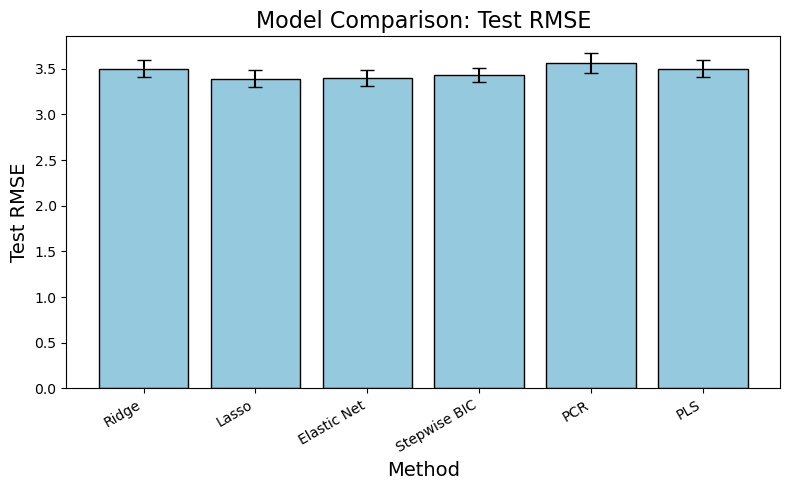

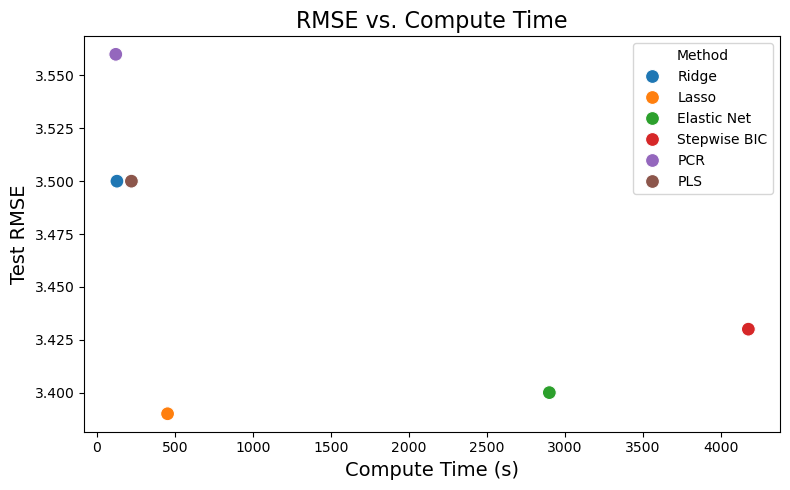

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Results df
results = pd.DataFrame({
    'Method': ['Ridge', 'Lasso', 'Elastic Net', 'Stepwise BIC', 'PCR', 'PLS'],
    'RMSE_CV': [1.87, 1.85, 1.85, 1.86, 1.89, 1.87],
    'RMSE_CV_std': [0.09, 0.09, 0.09, 0.08, 0.11, 0.09],
    'RMSE_Test': [3.50, 3.39, 3.40, 3.43, 3.56, 3.50],
    'Num_Predictors': [7390, 335, 1496, 39, 30, 20],
    'Time_s': [128.61, 453.23, 2901.38, 4177.60, 121.20, 221.45]
})

# Bar Chart with CV error bars
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results,
    x='Method',
    y='RMSE_Test',
    color='skyblue',
    edgecolor='black'
)

for i, row in results.iterrows():
    plt.errorbar(
        x=i,                     
        y=row['RMSE_Test'],       
        yerr=row['RMSE_CV_std'],  
        fmt='none',               
        ecolor='black',          
        capsize=5                 
    )

plt.title("Model Comparison: Test RMSE", fontsize=16)
plt.ylabel("Test RMSE", fontsize=14)
plt.xlabel("Method", fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=results, x='Time_s', y='RMSE_Test', hue='Method', s=100)

# Plotting RMSE vs. Compute Time
plt.title("RMSE vs. Compute Time", fontsize=16)
plt.xlabel("Compute Time (s)", fontsize=14)
plt.ylabel("Test RMSE", fontsize=14)
plt.legend(title="Method")
plt.tight_layout()
plt.show()
